In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import platform
import re
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False 

if platform.system() == 'Darwin': 
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic') 

In [988]:
from glob import glob
files = glob("./dataset/supply_chain/*.xls")

In [4]:
df_list = [] 
for file in files:
    df_raw = pd.read_excel(file, "Table1", 
                      dtype={
                          'No':int,
                          '일자':str,
                          '매출처':str,
                          '코드':str,
                          '품목명': str,
                          '규격': str,
                          '원산지': str,
                          '단위': str,
                          '수량': float,
                          '단가': float,
                          '합계': float,
                          '금액': float,
                          '세액': float,
                          '비고': str                          
                      }
        )
    df_list.append(df_raw)
    


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

In [1049]:
df_raw = pd.concat(df_list)


In [1050]:
df_raw.head()

,No,일자,매출처,코드,품목명,규격,원산지,단위,수량,단가,합계,금액,세액,비고
0,1,20211201,가은요양원,1028369,(직) 데친고사리 1kg(냉장},(냉장)1kg 팩포장,중국산,Kg,2.0,4030.0,8060.0,8060.0,0.0,NaN
1,2,20211201,가은요양원,1105057,(직) 깐도라지채 1kg(냉장},(냉장)1kg,중국산,팩,2.0,7040.0,14080.0,14080.0,0.0,NaN
2,3,20211201,가은요양원,1093670,콩나물 박스 4kg(상 곱슬이),박스 4kg,"수입대두(중국,미국,캐나다)",Box,1.0,5100.0,5100.0,5100.0,0.0,NaN
3,4,20211201,가은요양원,1003475,*삼색수제비 1kg(동성 냉동),(냉동)1kg,국내,PK,2.0,2750.0,6050.0,5500.0,550.0,NaN
4,5,20211201,가은요양원,1091376,*)자숙바지락살 350g(냉동),(냉동)350g/팩,중국산,팩,5.0,2420.0,13310.0,12100.0,1210.0,NaN


In [553]:
df_raw.shape

(872824, 14)

# Data Filtering 

In [1051]:
df_raw.fillna("", inplace=True)
df_raw.rename(columns={"일자":"day","매출처":"vendor","코드":"code","수량":"count", "단가":"price", "합계":"total", "금액":"sum", "세액":"tax", "비고":"etc"}, inplace=True)
df_raw = df_raw[df_raw["etc"].str.contains("취소")==False]
df_raw = df_raw[df_raw["etc"].str.contains("반품")==False]
df_raw = df_raw[df_raw["count"]!=0]
df_raw = df_raw.drop(df_raw[df_raw["day"]=="소계"].index)
df_raw = df_raw.drop(df_raw[df_raw["day"]=="합계"].index)
print(df_raw.shape)

(857497, 14)


In [1052]:
df = df_raw.copy()
del df_raw

In [1053]:
df.drop(columns=["No","규격","단위","total","tax","etc"], inplace=True)
df.head()

,day,vendor,code,품목명,원산지,count,price,sum
0,20211201,가은요양원,1028369,(직) 데친고사리 1kg(냉장},중국산,2.0,4030.0,8060.0
1,20211201,가은요양원,1105057,(직) 깐도라지채 1kg(냉장},중국산,2.0,7040.0,14080.0
2,20211201,가은요양원,1093670,콩나물 박스 4kg(상 곱슬이),"수입대두(중국,미국,캐나다)",1.0,5100.0,5100.0
3,20211201,가은요양원,1003475,*삼색수제비 1kg(동성 냉동),국내,2.0,2750.0,5500.0
4,20211201,가은요양원,1091376,*)자숙바지락살 350g(냉동),중국산,5.0,2420.0,12100.0


In [1054]:
# Number of raw data
df.rename(columns={"일자":"day","매출처":"customer","code":"product","품목명":"product_name","원산지":"origin", "수량":"quantity","단가":"price","금액":"aggregate"}, inplace=True) 
print(df.shape) 

(857497, 8)


In [563]:
# Number of unique product
prodlist = df["product_name"].unique()
print(len(prodlist))

20977


In [564]:
# Number of unique product
len(df["product"].unique())


23302

In [565]:
df["product_name"].value_counts()

(직) 취청오이 kg(생)                 7318
(직) 쥬키니호박 kg(생)                6215
(직) 흙대파 kg(생 끝 절단안함)           6103
*손맛판두부 3kg(부침용 해두른 냉장)**       6052
(직) 부추 kg(생 조선부추)              5064
                               ... 
마늘맛가루 450g(이슬나라 실온)               1
칠리시즈닝 450g(식자재왕 실온)               1
터메릭분말 500g(심황분말 은진 실온)            1
큐민분말 450g(스위트웰 실온)                1
니트릴장갑 ea(파랑색_중 100개 CJ 이츠웰)       1
Name: product_name, Length: 20977, dtype: int64

In [1055]:
df["day"] = pd.to_datetime(df["day"])
df['month']=df['day'].dt.strftime("%m")    
df["ym"] = df["day"].apply(lambda row : row.strftime("%Y%m"))
df.head()

,day,vendor,product,product_name,origin,count,price,sum,month,ym
0,2021-12-01,가은요양원,1028369,(직) 데친고사리 1kg(냉장},중국산,2.0,4030.0,8060.0,12,202112
1,2021-12-01,가은요양원,1105057,(직) 깐도라지채 1kg(냉장},중국산,2.0,7040.0,14080.0,12,202112
2,2021-12-01,가은요양원,1093670,콩나물 박스 4kg(상 곱슬이),"수입대두(중국,미국,캐나다)",1.0,5100.0,5100.0,12,202112
3,2021-12-01,가은요양원,1003475,*삼색수제비 1kg(동성 냉동),국내,2.0,2750.0,5500.0,12,202112
4,2021-12-01,가은요양원,1091376,*)자숙바지락살 350g(냉동),중국산,5.0,2420.0,12100.0,12,202112


In [ ]:
###### A latest whole year data 
df_12months=df[df["ym"] > "202012"]
print(df_12months.head(7))
print(len(df_12months))

In [20]:
df_12months.sort_values(by='ym', ascending=True)


,day,customer,product,product_name,origin,quantity,price,aggregate,month,ym
13127,2021-01-12,효사랑전주병원,1041546,(NH) 자숙바지락살 1kg(냉동),중국산,1.0,6100.0,6100.0,01,202101
23793,2021-01-21,박천수정형외과의원,1028336,(직) 팽이버섯 kg(생),국내산,1.0,2840.0,2840.0,01,202101
23792,2021-01-21,박천수정형외과의원,1098172,*깐양상추 kg(생),국내산,1.5,3620.0,5430.0,01,202101
23791,2021-01-21,박천수정형외과의원,1046340,*콩나물 박스 4kg(상 곱슬이)**..,"수입대두(중국,미국,캐나다)",1.0,3870.0,3870.0,01,202101
23790,2021-01-21,박천수정형외과의원,1039039,*손맛판두부 3kg(부침용 해두른 냉장)**,대두:외국산,2.0,4140.0,8280.0,01,202101
...,...,...,...,...,...,...,...,...,...,...
32534,2021-12-22,김제노인복지센터,1028313,(직) 참나물 박스 4kg(생),국내산,1.0,20740.0,20740.0,12,202112
32533,2021-12-22,김제노인복지센터,1141886,(직) 일반새송이버섯 박스 2kg(생 실속형),국내산,2.0,10300.0,20600.0,12,202112
32532,2021-12-22,김제노인복지센터,1042574,*NH) 고등어토막 kg(특 소제 구이용 70~80g 노르웨이산 지느러미제거),노르웨이산,4.0,8520.0,34080.0,12,202112
32541,2021-12-22,김제노인복지센터,1049415,*)일품당면 1kg(에스비 쉐프초이스 실온),중국산,2.0,4060.0,8120.0,12,202112


In [21]:
df_12months_pivot = df_12months.pivot_table(
    index="product", 
    columns=["ym"], 
    values="quantity", 
    fill_value=0,
    aggfunc=np.sum)
df_12months_pivot.head()

ym,202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,
1000025,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000026,0.0,0.0,1.0,3.0,11.0,9.0,6.0,19.0,15.0,13.0,9.0,4.0
1000028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000043,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0
1000052,6.0,3.0,9.0,7.0,6.0,9.0,6.0,10.0,3.0,0.0,0.0,0.0


In [22]:
def calc_event_density(datasets: list):
    bin_dataset = [1 if element > 0 else 0 for element in datasets ]
    return np.mean(bin_dataset)-np.var(bin_dataset)


In [23]:
# The number of unique product
df_12months_pivot.shape

(18367, 12)

In [539]:
df_12months.head()


AttributeError: 'NoneType' object has no attribute 'head'

In [538]:
len(df_12months['customer'].unique())

TypeError: 'NoneType' object is not subscriptable

In [30]:
df_12months_pivot["density"] = df_12months_pivot.apply(lambda row: calc_event_density(row), axis=1)
df_12months_pivot.head()

ym,202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112,density
product,,,,,,,,,,,,,
1000025,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053254
1000026,0.0,0.0,1.0,3.0,11.0,9.0,6.0,19.0,15.0,13.0,9.0,4.0,0.715976
1000028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023669
1000043,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.147929
1000052,6.0,3.0,9.0,7.0,6.0,9.0,6.0,10.0,3.0,0.0,0.0,0.0,0.591716


In [31]:
df_12months_pivot["density"].describe()

count    18367.000000
mean         0.234619
std          0.301696
min          0.000000
25%          0.023669
50%          0.094675
75%          0.289941
max          1.000000
Name: density, dtype: float64

In [32]:
len(df_12months_pivot[df_12months_pivot.density > 0.7 ])


2441

In [33]:
len(df_12months_pivot[df_12months_pivot.density > 0.9 ])


1370

In [ ]:
# =====>>>> NEED TO CUTOFF BETWEEN 500~1000 products

In [38]:
# A latest half a year data 
df_6months=df[df["ym"] > "202105"]
print(df_6months.head())
print(len(df_6months))

         day customer  product       product_name           origin  quantity  \
0 2021-12-01    가은요양원  1028369  (직) 데친고사리 1kg(냉장}              중국산       2.0   
1 2021-12-01    가은요양원  1105057  (직) 깐도라지채 1kg(냉장}              중국산       2.0   
2 2021-12-01    가은요양원  1093670  콩나물 박스 4kg(상 곱슬이)  수입대두(중국,미국,캐나다)       1.0   
3 2021-12-01    가은요양원  1003475  *삼색수제비 1kg(동성 냉동)               국내       2.0   
4 2021-12-01    가은요양원  1091376  *)자숙바지락살 350g(냉동)              중국산       5.0   

    price  aggregate month      ym  
0  4030.0     8060.0    12  202112  
1  7040.0    14080.0    12  202112  
2  5100.0     5100.0    12  202112  
3  2750.0     5500.0    12  202112  
4  2420.0    12100.0    12  202112  
308734


In [40]:
df_6months_pivot = df_6months.pivot_table(
    index="product", 
    columns=["ym"], 
    values="quantity", 
    fill_value=0,
    aggfunc=np.sum)
df_6months_pivot.head()

ym,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,
1000026,9.0,6.0,19.0,15.0,13.0,9.0,4.0
1000043,2.0,0.0,0.0,1.0,0.0,0.0,4.0
1000052,9.0,6.0,10.0,3.0,0.0,0.0,0.0
1000058,0.0,1.0,0.0,0.0,2.0,0.0,1.0
1000074,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [ ]:
df_6months_pivot

(15359, 7)

In [42]:
len(df_6months['product'].unique())

15359

In [43]:
df_6months_pivot["density"] = df_6months_pivot.apply(lambda row: calc_event_density(row), axis=1)
df_6months_pivot.head()

ym,202106,202107,202108,202109,202110,202111,202112,density
product,,,,,,,,
1000026,9.0,6.0,19.0,15.0,13.0,9.0,4.0,1.000000
1000043,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.183673
1000052,9.0,6.0,10.0,3.0,0.0,0.0,0.0,0.326531
1000058,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.183673
1000074,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.020408


In [48]:
df_6months_pivot["density"].describe()

count    15359.000000
mean         0.297468
std          0.353387
min          0.000000
25%          0.020408
50%          0.081633
75%          0.510204
max          1.000000
Name: density, dtype: float64

In [45]:
len(df_6months_pivot[df_6months_pivot.density > 0.7 ])


3272

In [46]:
len(df_6months_pivot[df_6months_pivot.density > 0.9 ])


2242

In [49]:
import matplotlib.pyplot as plt

plt.close("all")

<AxesSubplot:xlabel='product'>

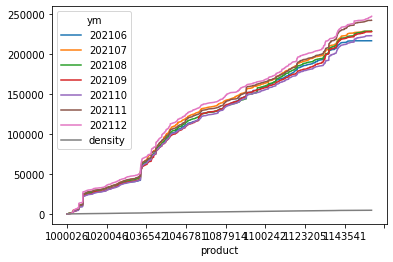

In [53]:
df_6months_pivot.cumsum().plot()

<AxesSubplot:xlabel='product'>

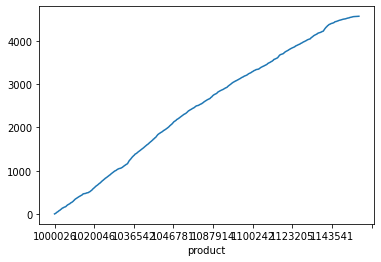

In [55]:
df_6months_pivot["density"].cumsum().plot()

<AxesSubplot:xlabel='product'>

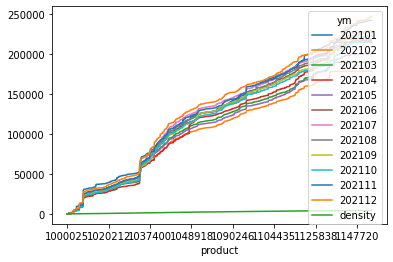

In [56]:
df_12months_pivot.cumsum().plot()

<AxesSubplot:>

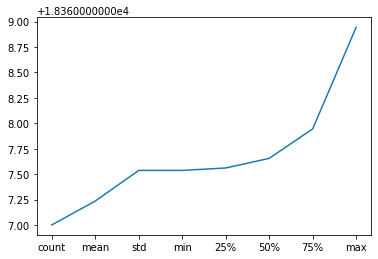

In [54]:
df_12months_pivot["density"].describe().cumsum().plot()

In [ ]:
# =====>>>> NEED TO CUTOFF BETWEEN 500~1000 products


In [57]:
# 2 whole years
df_24months_pivot = df.pivot_table(
    index="product", 
    columns=["ym"], 
    values="quantity", 
    fill_value=0,
    aggfunc=np.sum)
df_24months_pivot.head()

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000025,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000026,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,11.0,9.0,6.0,19.0,15.0,13.0,9.0,4.0
1000028,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000043,4.0,9.0,5.0,3.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0
1000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_24months_pivot

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000025,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000026,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,11.0,9.0,6.0,19.0,15.0,13.0,9.0,4.0
1000028,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000043,4.0,9.0,5.0,3.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0
1000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
1160378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1160381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0


In [60]:
len(df["product"].unique())

23390

In [349]:
df_24months_pivot["density"] = df_24months_pivot.apply(lambda row: calc_event_density(row), axis=1)
df_24months_pivot.head()

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202104,202105,202106,202107,202108,202109,202110,202111,202112,density
product,,,,,,,,,,,,,,,,,,,,,
1000025,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778
1000026,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,11.0,9.0,6.0,19.0,15.0,13.0,9.0,4.0,0.250000
1000028,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006944
1000043,4.0,9.0,5.0,3.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.250000
1000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006944


In [62]:
df_24months_pivot["density"].describe()

count    23390.000000
mean         0.132713
std          0.247266
min          0.000000
25%          0.001736
50%          0.015625
75%          0.111111
max          1.000000
Name: density, dtype: float64

In [64]:
len(df_24months_pivot[df_24months_pivot.density > 0.7 ])


1423

In [350]:
# Appropriate size
len(df_24months_pivot[df_24months_pivot.density > 0.9 ])



967

In [352]:
df_24months=df_24months_pivot[df_24months_pivot.density > 0.9 ]
df_24months.drop(columns=["density"], inplace=True)


In [567]:
df_24months

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000203,2.0,2.0,4.0,3.0,4.0,2.0,3.0,2.0,3.0,1.0,...,3.0,2.5,2.0,2.0,1.0,0.0,3.5,1.0,1.0,2.0
1000229,2.0,1.0,0.0,1.0,10.0,7.0,3.0,6.0,4.0,7.0,...,5.0,9.0,6.0,5.0,12.0,6.0,4.0,3.0,1.0,1.0
1000232,6.0,6.0,6.0,14.0,24.0,11.0,10.0,12.0,22.0,8.0,...,4.0,5.0,3.0,4.0,4.0,10.0,3.0,3.0,8.0,2.0
1000284,47.5,0.0,68.0,87.0,66.0,113.5,127.0,114.0,117.0,75.0,...,40.5,43.5,53.0,59.0,43.5,48.5,24.0,44.5,109.0,65.0
1000463,2.0,2.0,2.0,12.0,7.0,7.0,6.0,10.0,18.0,5.0,...,21.0,5.0,14.0,12.0,17.0,27.0,17.0,10.0,14.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119803,0.0,22.0,59.0,40.0,27.0,39.0,27.0,42.0,54.0,45.0,...,46.0,41.0,45.0,40.0,56.0,38.0,32.0,33.0,40.0,56.0
1119809,0.0,40.0,113.0,48.0,79.0,104.0,90.0,84.0,69.0,28.0,...,51.0,40.0,106.0,118.0,138.0,122.0,138.0,120.0,133.0,135.0
1119899,0.0,12.0,8.0,10.0,13.0,14.0,10.0,12.0,16.0,12.0,...,12.0,6.0,10.0,14.0,10.0,8.0,12.0,8.0,12.0,13.0


In [574]:
df_24months.to_csv('df_24months.csv')

<AxesSubplot:xlabel='product'>

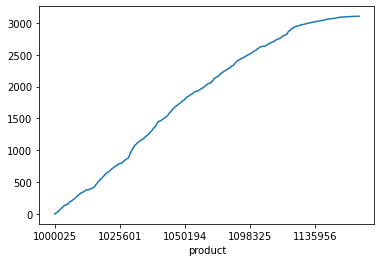

In [66]:
df_24months_pivot["density"].cumsum().plot()


In [ ]:
# x,y axis explanation
# density explanation
# explain why we are going to use this

In [354]:
df_24months.index

Index(['1000203', '1000229', '1000232', '1000284', '1000463', '1000480',
       '1000540', '1000618', '1000626', '1000665',
       ...
       '1119783', '1119785', '1119789', '1119793', '1119795', '1119803',
       '1119809', '1119899', '1120219', '1120647'],
      dtype='object', name='product', length=967)

In [449]:
df_24months.values[:10]

array([[  2. ,   2. ,   4. ,   3. ,   4. ,   2. ,   3. ,   2. ,   3. ,
          1. ,   4. ,   2. ,   1.5,   3. ,   3. ,   2.5,   2. ,   2. ,
          1. ,   0. ,   3.5,   1. ,   1. ,   2. ],
       [  2. ,   1. ,   0. ,   1. ,  10. ,   7. ,   3. ,   6. ,   4. ,
          7. ,  15. ,  10. ,  12. ,  10. ,   5. ,   9. ,   6. ,   5. ,
         12. ,   6. ,   4. ,   3. ,   1. ,   1. ],
       [  6. ,   6. ,   6. ,  14. ,  24. ,  11. ,  10. ,  12. ,  22. ,
          8. ,  19. ,  10. ,  11. ,  12. ,   4. ,   5. ,   3. ,   4. ,
          4. ,  10. ,   3. ,   3. ,   8. ,   2. ],
       [ 47.5,   0. ,  68. ,  87. ,  66. , 113.5, 127. , 114. , 117. ,
         75. ,  90.5,  42.5,  25. ,  31.5,  40.5,  43.5,  53. ,  59. ,
         43.5,  48.5,  24. ,  44.5, 109. ,  65. ],
       [  2. ,   2. ,   2. ,  12. ,   7. ,   7. ,   6. ,  10. ,  18. ,
          5. ,   4. ,   6. ,   9. ,   8. ,  21. ,   5. ,  14. ,  12. ,
         17. ,  27. ,  17. ,  10. ,  14. ,   6. ],
       [  5. ,   7. ,   3. ,   3. ,

In [357]:
df_24months.values[0]

array([2. , 2. , 4. , 3. , 4. , 2. , 3. , 2. , 3. , 1. , 4. , 2. , 1.5,
       3. , 3. , 2.5, 2. , 2. , 1. , 0. , 3.5, 1. , 1. , 2. ])

In [411]:
temp = df_24months[df_24months.index == '1000203']
temp


ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000203,2.0,2.0,4.0,3.0,4.0,2.0,3.0,2.0,3.0,1.0,...,3.0,2.5,2.0,2.0,1.0,0.0,3.5,1.0,1.0,2.0


In [433]:
df_24months.iloc[0]

ym
202001    2.0
202002    2.0
202003    4.0
202004    3.0
202005    4.0
202006    2.0
202007    3.0
202008    2.0
202009    3.0
202010    1.0
202011    4.0
202012    2.0
202101    1.5
202102    3.0
202103    3.0
202104    2.5
202105    2.0
202106    2.0
202107    1.0
202108    0.0
202109    3.5
202110    1.0
202111    1.0
202112    2.0
Name: 1000203, dtype: float64

In [413]:
temp.iloc[0]

ym
202001    2.0
202002    2.0
202003    4.0
202004    3.0
202005    4.0
202006    2.0
202007    3.0
202008    2.0
202009    3.0
202010    1.0
202011    4.0
202012    2.0
202101    1.5
202102    3.0
202103    3.0
202104    2.5
202105    2.0
202106    2.0
202107    1.0
202108    0.0
202109    3.5
202110    1.0
202111    1.0
202112    2.0
Name: 1000203, dtype: float64

In [447]:
index_len=len(df_24months.index)
index_lena

967

In [385]:
values_count=len(df_24months.values[0])
values_count

24

In [ ]:
(dfasf)

In [398]:
# for i in df_24months.values:
#     print(i)

In [452]:
len(df_24months.values[0])

24

In [502]:
df_24months.head()

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000203,2.0,2.0,4.0,3.0,4.0,2.0,3.0,2.0,3.0,1.0,...,3.0,2.5,2.0,2.0,1.0,0.0,3.5,1.0,1.0,2.0
1000229,2.0,1.0,0.0,1.0,10.0,7.0,3.0,6.0,4.0,7.0,...,5.0,9.0,6.0,5.0,12.0,6.0,4.0,3.0,1.0,1.0
1000232,6.0,6.0,6.0,14.0,24.0,11.0,10.0,12.0,22.0,8.0,...,4.0,5.0,3.0,4.0,4.0,10.0,3.0,3.0,8.0,2.0
1000284,47.5,0.0,68.0,87.0,66.0,113.5,127.0,114.0,117.0,75.0,...,40.5,43.5,53.0,59.0,43.5,48.5,24.0,44.5,109.0,65.0
1000463,2.0,2.0,2.0,12.0,7.0,7.0,6.0,10.0,18.0,5.0,...,21.0,5.0,14.0,12.0,17.0,27.0,17.0,10.0,14.0,6.0


In [504]:
df_24months.values[:3]

array([[ 2. ,  2. ,  4. ,  3. ,  4. ,  2. ,  3. ,  2. ,  3. ,  1. ,  4. ,
         2. ,  1.5,  3. ,  3. ,  2.5,  2. ,  2. ,  1. ,  0. ,  3.5,  1. ,
         1. ,  2. ],
       [ 2. ,  1. ,  0. ,  1. , 10. ,  7. ,  3. ,  6. ,  4. ,  7. , 15. ,
        10. , 12. , 10. ,  5. ,  9. ,  6. ,  5. , 12. ,  6. ,  4. ,  3. ,
         1. ,  1. ],
       [ 6. ,  6. ,  6. , 14. , 24. , 11. , 10. , 12. , 22. ,  8. , 19. ,
        10. , 11. , 12. ,  4. ,  5. ,  3. ,  4. ,  4. , 10. ,  3. ,  3. ,
         8. ,  2. ]])

In [468]:
len(df_24months.columns)

24

In [880]:
# Scaling the dataset with RobustScaler

# x_sc = StandardScaler()
# y_sc = StandardScaler()

rc = RobustScaler()
# y_rc = RobustScaler()
scaled_data = pd.DataFrame(rc.fit_transform(df_24months))
scaled_data.head()
# scaled_x_train_list = x_rc.fit_transform(df_24months.values)
# scaled_y_train_list = x_rc.transform(y_train_list)
# scaled_y_train_list = y_rc.fit_transform(y_train_list)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.282857,-0.298507,-0.279070,-0.313316,-0.329114,-0.415584,-0.396733,-0.405063,-0.377778,-0.401786,...,-0.358491,-0.401961,-0.386643,-0.360656,-0.411667,-0.428571,-0.354545,-0.353982,-0.3424,-0.344262
1,-0.282857,-0.328358,-0.372093,-0.365535,-0.177215,-0.285714,-0.396733,-0.303797,-0.355556,-0.267857,...,-0.320755,-0.274510,-0.316344,-0.311475,-0.228333,-0.321429,-0.345455,-0.321802,-0.3424,-0.360656
2,-0.168571,-0.179104,-0.232558,-0.026110,0.177215,-0.181818,-0.233372,-0.151899,0.044444,-0.245536,...,-0.339623,-0.352941,-0.369069,-0.327869,-0.361667,-0.250000,-0.363636,-0.321802,-0.2304,-0.344262
3,1.017143,-0.358209,1.209302,1.879896,1.240506,2.480519,2.497083,2.430380,2.155556,1.250000,...,0.349057,0.401961,0.509666,0.573770,0.296667,0.437500,0.018182,0.345937,1.3856,0.688525
4,-0.282857,-0.298507,-0.325581,-0.078329,-0.253165,-0.285714,-0.326721,-0.202532,-0.044444,-0.312500,...,-0.018868,-0.352941,-0.175747,-0.196721,-0.145000,0.053571,-0.109091,-0.209171,-0.1344,-0.278689


In [881]:
df_24months_scaled=df_24months.copy()
df_24months_scaled=df_24months_scaled.replace(df_24months_scaled.values, scaled_data.values)
len(df_24months_scaled)
df_24months_scaled.head()

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000203,-0.340000,-0.278481,-0.339623,-0.289622,0.075949,-0.065217,-0.378333,-0.059701,-0.377778,-0.196078,...,-0.255814,-0.390625,0.070299,1.311475,-0.233372,-0.153846,-0.363636,0.130548,-0.431818,0.344262
1000229,-0.059701,-0.266667,-0.019608,-0.102400,-0.285714,-0.191489,-0.321429,-0.186047,-0.223214,0.070299,...,0.130548,-0.431818,-0.163934,-0.340000,-0.278481,-0.188679,0.048270,-0.253165,0.108696,-0.345000
1000232,-0.186047,-0.156250,-0.246046,-0.163934,-0.233372,-0.153846,0.309091,-0.130548,0.000000,-0.163934,...,0.075949,0.108696,-0.378333,-0.059701,-0.266667,-0.019608,-0.262400,-0.259740,-0.255319,0.107143
1000284,-0.052219,0.000000,0.721311,0.288571,0.455696,-0.018868,1.367659,1.908861,3.021739,0.238333,...,0.051948,0.893617,0.857143,1.488372,0.781250,1.704745,-0.360656,1.159860,0.241758,0.763636
1000463,-0.177215,-0.065217,0.371667,-0.059701,-0.288889,-0.019608,-0.166400,-0.285714,-0.255319,0.107143,...,-0.233372,-0.263736,-0.200000,-0.130548,0.000000,0.262295,-0.340000,-0.278481,-0.188679,-0.241352


In [786]:
# windows_size=3
# target_size = 1

# all_set = []

# for i, row in scaled_data.iterrows():
#     row = row.to_list()
#     temp = []
#     for j in range(len(row) - (windows_size + target_size) + 1):
#         s = j
#         m = s + windows_size
#         e = m + target_size
#         temp.append((row[s: m], row[m: e]))
#     all_set.append(temp)

In [689]:
scaled_data.shape, len(all_set), len(all_set[0])

((967, 24), 967, 21)

In [797]:
for i in range(len(all_set[0][0]

([-0.28285714285714286, -0.29850746268656714, -0.27906976744186046],
 [-0.3133159268929504])

In [882]:
windows_size=3
target_size=1
all_set=[]
X_train11 = []
Y_train11 = []
len_values=len(df_24months_scaled.values)

for index, row in df_24months_scaled.iterrows(): # 0:n1 1:n2 3:n3...
    row=row.to_list()
    temp=[]
    for s in range(len(row)-(windows_size)):
        m=s+windows_size
        e=m+target_size
        x_val=row[s:m]
        y_val=row[m:e]
        # X_train.append(x_val)

    
        temp.append((x_val,y_val))
    all_set.append(temp)

In [900]:
df_all_set=pd.DataFrame(all_set)
df_all_set

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,"([-0.34, -0.27848101265822783, -0.339622641509...","([-0.27848101265822783, -0.33962264150943394, ...","([-0.33962264150943394, -0.28962188254223653, ...","([-0.28962188254223653, 0.0759493670886076, -0...","([0.0759493670886076, -0.06521739130434782, -0...","([-0.06521739130434782, -0.3783333333333333, -...","([-0.3783333333333333, -0.05970149253731343, -...","([-0.05970149253731343, -0.37777777777777777, ...","([-0.37777777777777777, -0.19607843137254902, ...","([-0.19607843137254902, -0.10239999999999998, ...",...,"([-0.2857142857142857, -0.3617021276595745, -0...","([-0.3617021276595745, -0.32142857142857145, -...","([-0.32142857142857145, -0.2558139534883721, -...","([-0.2558139534883721, -0.390625, 0.0702987697...","([-0.390625, 0.070298769771529, 1.311475409836...","([0.070298769771529, 1.3114754098360655, -0.23...","([1.3114754098360655, -0.23337222870478413, -0...","([-0.23337222870478413, -0.15384615384615385, ...","([-0.15384615384615385, -0.36363636363636365, ...","([-0.36363636363636365, 0.13054830287206268, -..."
1,"([-0.05970149253731343, -0.26666666666666666, ...","([-0.26666666666666666, -0.0196078431372549, -...","([-0.0196078431372549, -0.10239999999999998, -...","([-0.10239999999999998, -0.2857142857142857, -...","([-0.2857142857142857, -0.19148936170212766, -...","([-0.19148936170212766, -0.32142857142857145, ...","([-0.32142857142857145, -0.18604651162790697, ...","([-0.18604651162790697, -0.22321428571428573, ...","([-0.22321428571428573, 0.070298769771529, -0....","([0.070298769771529, -0.01639344262295082, -0....",...,"([-0.1633605600933489, -0.15384615384615385, 0...","([-0.15384615384615385, 0.3090909090909091, 0....","([0.3090909090909091, 0.13054830287206268, -0....","([0.13054830287206268, -0.4318181818181818, -0...","([-0.4318181818181818, -0.16393442622950818, -...","([-0.16393442622950818, -0.34, -0.278481012658...","([-0.34, -0.27848101265822783, -0.188679245283...","([-0.27848101265822783, -0.18867924528301888, ...","([-0.18867924528301888, 0.04827031375703942, -...","([0.04827031375703942, -0.25316455696202533, 0..."
2,"([-0.18604651162790697, -0.15625, -0.246045694...","([-0.15625, -0.2460456942003515, -0.1639344262...","([-0.2460456942003515, -0.16393442622950818, -...","([-0.16393442622950818, -0.23337222870478413, ...","([-0.23337222870478413, -0.15384615384615385, ...","([-0.15384615384615385, 0.3090909090909091, -0...","([0.3090909090909091, -0.13054830287206268, 0....","([-0.13054830287206268, 0.0, -0.16393442622950...","([0.0, -0.16393442622950818, -0.34], [-0.27848...","([-0.16393442622950818, -0.34, -0.278481012658...",...,"([-0.27848101265822783, 0.018867924528301886, ...","([0.018867924528301886, 0.33789219629927597, 0...","([0.33789219629927597, 0.0759493670886076, 0.1...","([0.0759493670886076, 0.10869565217391304, -0....","([0.10869565217391304, -0.3783333333333333, -0...","([-0.3783333333333333, -0.05970149253731343, -...","([-0.05970149253731343, -0.26666666666666666, ...","([-0.26666666666666666, -0.0196078431372549, -...","([-0.0196078431372549, -0.26239999999999997, -...","([-0.26239999999999997, -0.2597402597402597, -..."
3,"([-0.05221932114882507, 0.0, 0.721311475409836...","([0.0, 0.7213114754098361, 0.28857142857142853...","([0.7213114754098361, 0.28857142857142853, 0.4...","([0.28857142857142853, 0.45569620253164556, -0...","([0.45569620253164556, -0.018867924528301886, ...","([-0.018867924528301886, 1.3676588897827837, 1...","([1.3676588897827837, 1.908860759493671, 3.021...","([1.908860759493671, 3.0217391304347827, 0.238...","([3.0217391304347827, 0.23833333333333334, 4.3...","([0.23833333333333334, 4.3283582089552235, -0....",...,"([-0.06666666666666667, -0.19607843137254902, ...","([-0.19607843137254902, -0.2592, 0.05194805194...","([-0.2592, 0.05194805194805195, 0.893617021276...","([0.05194805194805195, 0.8936170212765957, 0.8...","([0.8936170212765957, 0.8571428571428571, 1.48...","([0.8571428571428571

In [883]:
all_set[0]

[([-0.34, -0.27848101265822783, -0.33962264150943394], [-0.28962188254223653]),
 ([-0.27848101265822783, -0.33962264150943394, -0.28962188254223653],
  [0.0759493670886076]),
 ([-0.33962264150943394, -0.28962188254223653, 0.0759493670886076],
  [-0.06521739130434782]),
 ([-0.28962188254223653, 0.0759493670886076, -0.06521739130434782],
  [-0.3783333333333333]),
 ([0.0759493670886076, -0.06521739130434782, -0.3783333333333333],
  [-0.05970149253731343]),
 ([-0.06521739130434782, -0.3783333333333333, -0.05970149253731343],
  [-0.37777777777777777]),
 ([-0.3783333333333333, -0.05970149253731343, -0.37777777777777777],
  [-0.19607843137254902]),
 ([-0.05970149253731343, -0.37777777777777777, -0.19607843137254902],
  [-0.10239999999999998]),
 ([-0.37777777777777777, -0.19607843137254902, -0.10239999999999998],
  [-0.2857142857142857]),
 ([-0.19607843137254902, -0.10239999999999998, -0.2857142857142857],
  [-0.3617021276595745]),
 ([-0.10239999999999998, -0.2857142857142857, -0.3617021276595

In [899]:
x = []
y = []
for i in range(len_values):
    X_train=all_set[i]
    for d in X_train:
        x.append(d[0])
        y.append(d[1])
#     # Y_value=all_set11[i][0][1]
# df_x=pd.DataFrame(x)
# df_x.head()
print(x[:10])
# print(y[:3])

[[-0.34, -0.27848101265822783, -0.33962264150943394], [-0.27848101265822783, -0.33962264150943394, -0.28962188254223653], [-0.33962264150943394, -0.28962188254223653, 0.0759493670886076], [-0.28962188254223653, 0.0759493670886076, -0.06521739130434782], [0.0759493670886076, -0.06521739130434782, -0.3783333333333333], [-0.06521739130434782, -0.3783333333333333, -0.05970149253731343], [-0.3783333333333333, -0.05970149253731343, -0.37777777777777777], [-0.05970149253731343, -0.37777777777777777, -0.19607843137254902], [-0.37777777777777777, -0.19607843137254902, -0.10239999999999998], [-0.19607843137254902, -0.10239999999999998, -0.2857142857142857]]


In [837]:
X_train

[-0.34, -0.05970149253731343, 0.4186046511627907]

In [836]:
months_scaled=df_24months.copy()
months_scaled.head()

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1000203,2.0,2.0,4.0,3.0,4.0,2.0,3.0,2.0,3.0,1.0,...,3.0,2.5,2.0,2.0,1.0,0.0,3.5,1.0,1.0,2.0
1000229,2.0,1.0,0.0,1.0,10.0,7.0,3.0,6.0,4.0,7.0,...,5.0,9.0,6.0,5.0,12.0,6.0,4.0,3.0,1.0,1.0
1000232,6.0,6.0,6.0,14.0,24.0,11.0,10.0,12.0,22.0,8.0,...,4.0,5.0,3.0,4.0,4.0,10.0,3.0,3.0,8.0,2.0
1000284,47.5,0.0,68.0,87.0,66.0,113.5,127.0,114.0,117.0,75.0,...,40.5,43.5,53.0,59.0,43.5,48.5,24.0,44.5,109.0,65.0
1000463,2.0,2.0,2.0,12.0,7.0,7.0,6.0,10.0,18.0,5.0,...,21.0,5.0,14.0,12.0,17.0,27.0,17.0,10.0,14.0,6.0


In [771]:
# windows_size=3
# target_size = 1
# # values_count = len(temp.columns)

# x_train_list = []
# y_train_list = []

# train_set_list = []


# for line in scaled_data.values:
#     for start in range(len(line) - (windows_size + target_size - 1)):
#         i = start
#         j = start + windows_size
#         k = start + windows_size + target_size
        
#         x_val = line[i: j].tolist()
#         y_val = line[j: k].tolist()
        
#         train_set_list.append([x_val, y_val])
        
#         # for i in range(index_len):
                
# #         x_val = df_24months.iloc[i][step:step+windows_size].tolist()
# #         y_val = df_24months.iloc[i][step+windows_size:step+windows_size+target_size].tolist()
# #         # print(f"{x_val}->>{y_val}")
#         x_train_list.append(x_val)
#         y_train_list.append(y_val)
# #         train_set_list.append((x_val,y_val))
# # print(len(train_set_list[:]))
# # print(train_set_list[:10])

In [772]:
x_train_list[:2]


[[-0.28285714285714286, -0.29850746268656714, -0.27906976744186046],
 [-0.29850746268656714, -0.27906976744186046, -0.3133159268929504]]

In [517]:
len(train_set_list)

20307

In [532]:
print(x_train_list[0], y_train_list[0])

[-0.28285714285714286, -0.29850746268656714, -0.27906976744186046] [-0.3133159268929504]


In [519]:
df_24months.values.ndim

2

In [520]:

# windows_size=3
# target_size = 1
# values_count = len(temp.columns)

# # x_train_list = []
# # y_train_list = []

# train_set_list = []

# for step in range(0,values_count - (windows_size+target_size)):
#     x_val = temp.iloc[0][step:step+windows_size].tolist()
#     y_val = temp.iloc[0][step+windows_size:step+windows_size+target_size].tolist()
#     print(f"{x_val}->>{y_val}")
#     # x_train_list.append(x_val)
#     # y_train_list.append(y_val)
#     train_set_list.append((x_val,y_val))


In [521]:
# between low of density and high of density

In [523]:
# Testing with shuffle train data set

import random
# x = [[1,2], [2,3], [3,4], [4,5], [5,6], [6,8]]
random.shuffle(train_set_list)
print(train_set_list[0:1])

[[[1.3555555555555556, 0.7142857142857143, 1.0909090909090908], [0.9565217391304348]]]


In [478]:
# # Seperate dataset to x_train(window size) and y_train(target size)
# x_train_list = []
# y_train_list = []

# for element in train_set_list:
#     x_train_list.append(element[0])
#     y_train_list.append(element[1])
    

In [533]:
print(x_train_list[0])
print(y_train_list[1])

[-0.28285714285714286, -0.29850746268656714, -0.27906976744186046]
[-0.3291139240506329]


In [537]:
np.array(x_train_list).shape

(20307, 3)

In [534]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train_list, y_train_list)
pred_y = dtr.predict(x_train_list)
error_list= []
for pred,y in zip(pred_y, y_train_list):
    error_list.append(np.abs(pred-y))
    # print(f"pred:{pred} real:{y} diff:{pred-y}")
print(f"mae : {np.mean(np.array(error_list))}")


mae : 0.0030011033942435317


In [492]:
# dtr = DecisionTreeRegressor()
# dtr.fit(scaled_x_train_list, scaled_y_train_list)
# pred_y = dtr.predict(scaled_x_train_list)
# error_list= []
# for pred,y in zip(pred_y, scaled_y_train_list):
#     error_list.append(np.abs(pred-y))
#     # print(f"pred:{pred} real:{y} diff:{pred-y}")
# print(f"mae : {np.mean(np.array(error_list))}")


mae : 0.020638959237600757


In [901]:
# for x, pred in zip (pred_y,y_train_list):
#     print(f"real:{x}, pred:{pred}")

In [319]:
print(x_train_list)
print(y_train_list)

[[7.0, 6.0, 9.0], [6.0, 6.0, 3.0], [6.0, 3.0, 9.0], [3.0, 3.0, 6.0], [6.0, 6.0, 6.0], [3.0, 9.0, 7.0], [0.0, 6.0, 6.0], [9.0, 7.0, 6.0], [9.0, 6.0, 10.0], [3.0, 6.0, 6.0], [6.0, 6.0, 3.0], [3.0, 0.0, 0.0], [6.0, 6.0, 6.0], [6.0, 9.0, 6.0], [6.0, 3.0, 6.0], [6.0, 6.0, 3.0], [0.0, 0.0, 6.0], [6.0, 3.0, 3.0], [3.0, 6.0, 6.0], [6.0, 10.0, 3.0], [10.0, 3.0, 0.0]]
[[6.0], [3.0], [7.0], [6.0], [3.0], [6.0], [3.0], [9.0], [3.0], [6.0], [6.0], [0.0], [3.0], [10.0], [6.0], [9.0], [6.0], [6.0], [6.0], [0.0], [0.0]]


In [195]:
df_pivot.index

Index(['1000025', '1000026', '1000028', '1000043', '1000044', '1000046',
       '1000047', '1000051', '1000052', '1000057',
       ...
       '1160370', '1160371', '1160372', '1160373', '1160374', '1160377',
       '1160378', '1160381', '1160382', '1164567'],
      dtype='object', name='product', length=23390)

In [196]:
df_pivot.values[:]

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   2.,   7., ...,  13.,   9.,   4.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 290.],
       [  0.,   0.,   0., ...,   0.,   0.,   2.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.]])

In [197]:
df_pivot.values[:,1:]

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   7.,   0., ...,  13.,   9.,   4.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 290.],
       [  0.,   0.,   0., ...,   0.,   0.,   2.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.]])

In [ ]:
# Split the datasets

In [927]:
df_24months_scaled.values.shape

(967, 24)

In [960]:
# # book

# def datasets(df_24months_scaled, x_len=4, y_len=1, test_loops=1):
#     D=df_24months_scaled.values
#     rows,periods=D.shape
    
#     loops=periods+1-x_len-y_len
#     for col in range(loops):
#         col_arr=D[:,col:col+x_len+y_len]
#         train=np.vstack(col_arr)
#         X_train,Y_train=np.split(train,[-y_len],axis=1)
        
#         if test_loops>0:
#             X_train,X_test=np.split(X_train,[-rows*test_loops],axis=0)
#             Y_train,Y_test=np.split(Y_train,[-rows*test_loops],axis=0)
#         else:
#             X_test=D[:,-x_len:]
#             Y_test=np.full((X_test.shape[0],y_len),np.nan)
            
#         if y_len==1:
#             Y_train=Y_train.ravel()
#             Y_test=Y_test.ravel()
            
#     return X_train, Y_train, X_test,Y_test
#     # return X_train, len(X_train), Y_train, len(Y_train)


In [973]:
X_train, Y_train, X_test, Y_test = datasets(df_24months_scaled)

array([], dtype=float64)

In [957]:
datasets(df_24months_scaled)

(array([], shape=(0, 4), dtype=float64), 0, array([], dtype=float64), 0)

In [1004]:
# # blog
# # 24months

# def datasets(df_24months_scaled, x_len=3, y_len=1, y_test_len=3):
#     D=df_24months_scaled.values
#     periods=D.shape[1]
#     loops=periods+1-x_len-y_len-y_test_len

#     # print(loops)
#     for col in range(loops):
#         col_arr=D[:,col:col+x_len+y_len] #numpy.ndarray
#         train=np.vstack(col_arr)
#         X_train,Y_train=np.split(train,[x_len],axis=1)

#     max_col_test=periods-x_len-y_len+1
#     for col in range(loops,max_col_test):
#         col_arr=D[:,col:col+x_len+y_len]
#         test=np.vstack(col_arr)
#         X_test,Y_test=np.split(test,[x_len],axis=1)
        
#     if y_len==1:
#         Y_train=Y_train.ravel()
#         Y_test=Y_test.ravel()
    
#     return X_train, Y_train, X_test,Y_test
#     # return Y_train, len(Y_train)



In [1010]:
Y_test[:10]

array([ 0.3442623 , -0.345     ,  0.10714286,  0.76363636, -0.24135157,
       -0.1664    , -0.32622951, -0.34      ,  0.07462687, -0.25581395])

In [1011]:
# LinearRegression

from sklearn.linear_model import LinearRegression 
reg=LinearRegression()
reg=reg.fit(X_train, Y_train)

Y_train_pred_linear=reg.predict(X_train)
Y_test_pred_linear=reg.predict(X_test)



In [1012]:
# LinearRegression MAE
MAE_linear=np.mean(abs(Y_train-Y_train_pred_linear))/np.mean(Y_train)
print(round(MAE_linear*100,1))

76.1


In [1102]:
# DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor 
tree=DecisionTreeRegressor(max_depth=50, min_samples_split=15, min_samples_leaf=5)
tree.fit(X_train, Y_train)
Y_train_pred_tree=tree.predict(X_train)
Y_test_pred_tree=tree.predict(X_test)


In [1014]:
# DecisionTreeRegressor MAE

MAE_tree=np.mean(abs(Y_train-Y_train_pred_tree))/np.mean(Y_train)
print(round(MAE_tree*100,1))


68.4


In [1022]:
# KPI function(Key Performance Indicator)

def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df=pd.DataFrame(columns=['MAE','RMSE','BIAS'],index=['Train','Test'])
    df.index.name=name
    df.loc['Train', 'MAE']=100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train) 
    df.loc['Train', 'RMSE']=100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
    df.loc['Train', 'BIAS']=100*np.mean((Y_train-Y_train_pred))/np.mean(Y_train) 
    df.loc['Test', 'MAE']=100*np.mean(abs(Y_test-Y_test_pred))/np.mean(Y_test)
    df.loc['Test', 'RMSE']=100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
    df.loc['test', 'BIAS']=100*np.mean((Y_test-Y_test_pred))/np.mean(Y_test)
    df=df.astype(float).round(1)
    print(df)


In [ ]:
# tree 1-2
# -rnn
# -lstm
# -bd-lstm
# -attention
# at least more than 2 models among above

# from sklearn.svm import SVR #--option

In [1023]:
pd.DataFrame(kpi_ML(Y_train, Y_train_pred_linear, Y_test, Y_test_pred_linear, name='LinearRegression'))



                   MAE   RMSE  BIAS
LinearRegression                   
Train             76.1  169.1   0.0
Test              90.9  360.2   NaN
test               NaN    NaN   9.5


""


In [1103]:
pd.DataFrame(kpi_ML(Y_train, Y_train_pred_tree, Y_test, Y_test_pred_tree, name='DecisionTreeRegressor'))


                        MAE   RMSE  BIAS
DecisionTreeRegressor                   
Train                  56.3  188.0  -0.0
Test                   93.0  393.8   NaN
test                    NaN    NaN  -0.8


""


In [1029]:
datasets(df_24months_scaled, x_len=3, y_len=1, y_test_len=3)
forecast_linear=pd.DataFrame(data=reg.predict(X_test), index=df_24months_scaled.index)
forecast_linear.sort_values(by=[0],ascending=False)


,0
product,
1004291,70.693197
1038374,45.103820
1028145,30.729104
1028139,24.051388
1038398,22.585978
...,...
1028152,-0.389867
1079428,-0.425337
1007695,-0.884065


In [1045]:
df_24months[df_24months.index=='1028145']

ym,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,...,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
product,,,,,,,,,,,,,,,,,,,,,
1028145,2570.0,2390.0,2187.0,1965.0,1220.0,1206.0,1135.0,1405.0,3937.0,3221.0,...,3058.0,1862.0,1985.0,1790.0,1917.0,2132.0,1953.0,1900.0,1771.0,1873.0


In [1056]:
df.head()

,day,vendor,product,product_name,origin,count,price,sum,month,ym
0,2021-12-01,가은요양원,1028369,(직) 데친고사리 1kg(냉장},중국산,2.0,4030.0,8060.0,12,202112
1,2021-12-01,가은요양원,1105057,(직) 깐도라지채 1kg(냉장},중국산,2.0,7040.0,14080.0,12,202112
2,2021-12-01,가은요양원,1093670,콩나물 박스 4kg(상 곱슬이),"수입대두(중국,미국,캐나다)",1.0,5100.0,5100.0,12,202112
3,2021-12-01,가은요양원,1003475,*삼색수제비 1kg(동성 냉동),국내,2.0,2750.0,5500.0,12,202112
4,2021-12-01,가은요양원,1091376,*)자숙바지락살 350g(냉동),중국산,5.0,2420.0,12100.0,12,202112


In [1058]:
# 2 whole years
df_2years_pivot = df.pivot_table(
    index="product", 
    columns=["day"], 
    values="count", 
    fill_value=0,
    aggfunc=np.sum)
df_2years_pivot.head()

day,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,...,2021-12-21,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
product,,,,,,,,,,,,,,,,,,,,,
1000025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1059]:
df_2years_pivot["density"] = df_2years_pivot.apply(lambda row: calc_event_density(row), axis=1)
df_2years_pivot.head()

day,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-11 00:00:00,...,2021-12-22 00:00:00,2021-12-23 00:00:00,2021-12-24 00:00:00,2021-12-25 00:00:00,2021-12-27 00:00:00,2021-12-28 00:00:00,2021-12-29 00:00:00,2021-12-30 00:00:00,2021-12-31 00:00:00,density
product,,,,,,,,,,,,,,,,,,,,,
1000025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000039
1000026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.007119
1000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000010
1000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001077
1000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000022


In [1060]:
df_2years_pivot["density"].describe()

count    23302.000000
mean         0.009522
std          0.056676
min          0.000002
25%          0.000002
50%          0.000039
75%          0.000625
max          0.902500
Name: density, dtype: float64

In [1203]:
# blog
# 2 years
# 

def datasets(df, x_len=3, y_len=1, y_test_len=90):
    D=df.values
    periods=D.shape[1]
    loops=periods+1-x_len-y_len-y_test_len
    train, test = [], []
    
    # print(loops)
    for col in range(loops):
        col_arr=D[:,col:col+x_len+y_len] #numpy.ndarray        
        train.extend(np.vstack(col_arr))
    train = np.array(train)
    X_train,Y_train=np.split(train,[x_len],axis=1)

    max_col_test=periods-x_len-y_len+1
    for col in range(loops,max_col_test):
        col_arr=D[:,col:col+x_len+y_len]
        test.extend(np.vstack(col_arr))
    test = np.array(test)
    X_test,Y_test=np.split(test,[x_len],axis=1)
        
    if y_len==1:
        Y_train=Y_train.ravel()
        Y_test=Y_test.ravel()
    
    return X_train, Y_train, X_test, Y_test



In [1122]:
df_test = pd.read_csv("./df_24months.csv")

In [1205]:
len(df_test["product"].unique())

967

In [1210]:
uniq_items = [str(item) for item in df_test["product"].unique()]
print(type(uniq_items[0]))

<class 'str'>


In [1211]:
df_2years = df_2years_pivot[df_2years_pivot.index.isin(uniq_items)]


In [1212]:
df_2years.shape

(967, 640)

In [1213]:
df_2years.tail()

day,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,...,2021-12-21,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
product,,,,,,,,,,,,,,,,,,,,,
1119803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,10.0
1119809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,0.0,0.0,7.0,0.0,23.0,0.0,0.0,10.0,5.0
1119899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
1120219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0
1120647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,22.0,0.0,0.0,0.0,8.0,0.0,6.0


In [1219]:
X_train, Y_train, X_test, Y_test= datasets(df_2years)

In [1220]:
X_train.shape

(528949, 3)

In [1221]:
X_train[0]

array([0., 0., 0.])

In [1222]:
X_train[-1]

array([0., 0., 0.])

In [1223]:
# LinearRegression

from sklearn.linear_model import LinearRegression 
reg=LinearRegression()
reg=reg.fit(X_train, Y_train)

Y_train_pred_linear=reg.predict(X_train)
Y_test_pred_linear=reg.predict(X_test)



In [1224]:
# DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor 
tree=DecisionTreeRegressor(max_depth=5, min_samples_leaf=5)
tree.fit(X_train, Y_train)
Y_train_pred_tree=tree.predict(X_train)
Y_test_pred_tree=tree.predict(X_test)

In [1225]:
pd.DataFrame(kpi_ML(Y_train, Y_train_pred_linear, Y_test, Y_test_pred_linear, name='LinearRegression'))



                    MAE   RMSE  BIAS
LinearRegression                    
Train             110.7  469.6   0.0
Test              107.9  467.4   NaN
test                NaN    NaN   5.5


""


In [1226]:
# Scaling the dataset with RobustScaler

# x_sc = StandardScaler()
# y_sc = StandardScaler()

rc = RobustScaler()
# y_rc = RobustScaler()
scaled_data_2 = pd.DataFrame(rc.fit_transform(df_2years))
scaled_data_2.head()
# scaled_x_train_list = x_rc.fit_transform(df_24months.values)
# scaled_y_train_list = x_rc.transform(y_train_list)
# scaled_y_train_list = y_rc.fit_transform(y_train_list)


,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.5,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.5,2.0,0.0,...,10.0,2.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [1332]:
X_train_22, Y_train_22, X_test_22,Y_test_22 = datasets(scaled_data_2[0])

IndexError: tuple index out of range

In [1333]:
type(scaled_data_2[0])

pandas.core.series.Series

In [1242]:
# np.unique(Y_test_22)

In [1330]:
df_2years.shape

(967, 640)

In [1243]:
# LinearRegression

from sklearn.linear_model import LinearRegression 
reg=LinearRegression()
reg_22=reg.fit(X_train_22, Y_train_22)

Y_train_pred_linear_22=reg.predict(X_train_22)
Y_test_pred_linear_22=reg.predict(X_test_22)



In [1229]:
pd.DataFrame(kpi_ML(Y_train_22, Y_train_pred_linear_22, Y_test_22, Y_test_pred_linear_22, name='DecisionTreeRegressor'))



                         MAE   RMSE  BIAS
DecisionTreeRegressor                    
Train                  112.6  485.4   0.0
Test                   113.1  479.5   NaN
test                     NaN    NaN  -1.8


""


In [1246]:
from sklearn.ensemble import RandomForestRegressor 
forest=RandomForestRegressor(bootstrap=True, max_samples=0.95, min_samples_leaf=18, max_depth=7)
forest.fit(X_train_22, Y_train_22)

RandomForestRegressor(max_depth=7, max_samples=0.95, min_samples_leaf=18)

In [1247]:
Y_train_pred_random=forest.predict(X_train_22)
Y_test_pred_random=forest.predict(X_test_22)

In [1248]:
kpi_ML(Y_train_22, Y_train_pred_random, Y_test_22, Y_test_pred_random, name='RandomForestRegressor')

                         MAE   RMSE  BIAS
RandomForestRegressor                    
Train                  109.5  454.6   0.1
Test                   111.8  464.7   NaN
test                     NaN    NaN  -1.9


In [1249]:
forest_1=RandomForestRegressor(n_estimators=200, n_jobs=-1)
forest_1.fit(X_train_22, Y_train_22)
Y_train_pred_random_1=forest_1.predict(X_train_22)
Y_test_pred_random_1=forest_1.predict(X_test_22)
kpi_ML(Y_train_22, Y_train_pred_random_1, Y_test_22, Y_test_pred_random_1, name='RandomForestRegressor')

                         MAE   RMSE  BIAS
RandomForestRegressor                    
Train                   86.9  306.9  -0.7
Test                   116.5  498.6   NaN
test                     NaN    NaN  -5.5


In [1250]:
# LSTM
# Daily

df_2years.head()

day,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,...,2021-12-21,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
product,,,,,,,,,,,,,,,,,,,,,
1000203,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000229,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000232,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1000284,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.5,2.0,0.0,...,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000463,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1251]:
df_2years.index[0]

'1000203'

In [1255]:
len(df_2years.values[0])

640

In [1378]:
first_pro=df_2years.T['1028268']

first_pro=first_pro.to_frame(name='product')
first_pro.ndim

2

In [1379]:
train, test=first_pro[:-26], first_pro[-26:]

In [1380]:
scaler = StandardScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

In [1338]:
# from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [1356]:
# n_input=26
# n_features=1
# generator=TimeseriesGenerator(train, train, length=n_input, batch_size=6)
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dropout(0.15))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# model.fit_generator(generator,epochs=150)

In [1385]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [1386]:
model.input_shape

(None, 26, 1)

In [1357]:
# pred_list = []

# batch = train[-n_input:].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch)[0]) 
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [1341]:
# df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
#                           index=first_pro[-n_input:].index, columns=['Prediction'])

# df_test = pd.concat([first_pro,df_predict], axis=1)

In [1358]:
# df_test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


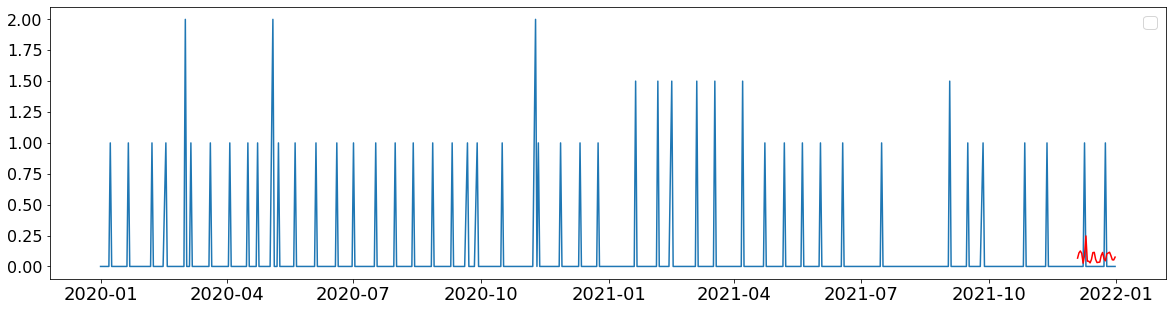

In [1342]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['product'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [1381]:
# Predicting Beyond the Dataset

train = first_pro
scaler.fit(train)
train = scaler.transform(train)
n_input = 26
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator,epochs=150)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/150
103/103 [==============================] - 2s 18ms/step - loss: 1.6668
Epoch 2/150
103/103 [==============================] - 2s 20ms/step - loss: 0.9413
Epoch 3/150
103/103 [==============================] - 2s 19ms/step - loss: 0.8870
Epoch 4/150
103/103 [==============================] - 2s 19ms/step - loss: 0.8876
Epoch 5/150
103/103 [==============================] - 2s 19ms/step - loss: 0.8668
Epoch 6/150
103/103 [==============================] - 2s 20ms/step - loss: 0.8567
Epoch 7/150
103/103 [==============================] - 2s 19ms/step - loss: 0.8553
Epoch 8/150
103/103 [==============================] - 2s 19ms/step - loss: 0.8517
Epoch 9/150
103/103 [==============================] - 2s 19ms/step - loss: 0.8427
Epoch 10/150
103/103 [==============================] - 2s 17ms/step - loss: 0.8443
Epoch 11/150
103/103 [==============================] - 2s 17ms/step - loss: 0.8313
Epoch 12/150
103/103 [==============================] - 2s 17ms/step - loss: 0.8327
E

In [1382]:
from pandas.tseries.offsets import DateOffset
add_dates = [first_pro.index[-1] + DateOffset(months=x) for x in range(0,27) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=first_pro.columns)
future_dates

,product
2022-01-31,NaN
2022-02-28,NaN
2022-03-31,NaN
2022-04-30,NaN
2022-05-31,NaN
2022-06-30,NaN
2022-07-31,NaN
2022-08-31,NaN
2022-09-30,NaN
2022-10-31,NaN


In [1383]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([first_pro,df_predict], axis=1)
df_proj

,product,Prediction
2020-01-01,0.0,NaN
2020-01-02,29.0,NaN
2020-01-03,18.0,NaN
2020-01-04,9.0,NaN
2020-01-06,35.5,NaN
...,...,...
2023-10-31,NaN,31.222709
2023-11-30,NaN,24.121924
2023-12-31,NaN,41.062675
2024-01-31,NaN,22.940190


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


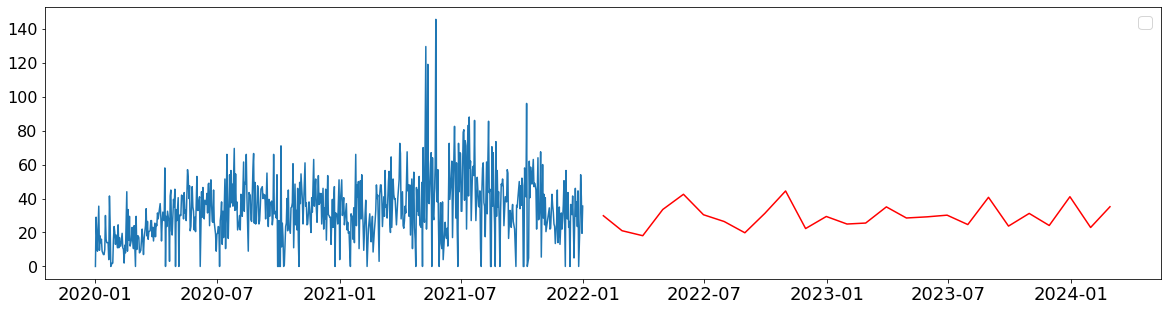

In [1384]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['product'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [1420]:
# LSTM
# Monthly

df.head()

,day,vendor,product,product_name,origin,count,price,sum,month,ym
0,2021-12-01,가은요양원,1028369,(직) 데친고사리 1kg(냉장},중국산,2.0,4030.0,8060.0,12,202112
1,2021-12-01,가은요양원,1105057,(직) 깐도라지채 1kg(냉장},중국산,2.0,7040.0,14080.0,12,202112
2,2021-12-01,가은요양원,1093670,콩나물 박스 4kg(상 곱슬이),"수입대두(중국,미국,캐나다)",1.0,5100.0,5100.0,12,202112
3,2021-12-01,가은요양원,1003475,*삼색수제비 1kg(동성 냉동),국내,2.0,2750.0,5500.0,12,202112
4,2021-12-01,가은요양원,1091376,*)자숙바지락살 350g(냉동),중국산,5.0,2420.0,12100.0,12,202112


In [1422]:
dfdf=df.copy()
dfdf['month']=dfdf['day'].dt.strftime("%Y-%m")    

dfdf.head()

,day,vendor,product,product_name,origin,count,price,sum,month,ym
0,2021-12-01,가은요양원,1028369,(직) 데친고사리 1kg(냉장},중국산,2.0,4030.0,8060.0,2021-12,202112
1,2021-12-01,가은요양원,1105057,(직) 깐도라지채 1kg(냉장},중국산,2.0,7040.0,14080.0,2021-12,202112
2,2021-12-01,가은요양원,1093670,콩나물 박스 4kg(상 곱슬이),"수입대두(중국,미국,캐나다)",1.0,5100.0,5100.0,2021-12,202112
3,2021-12-01,가은요양원,1003475,*삼색수제비 1kg(동성 냉동),국내,2.0,2750.0,5500.0,2021-12,202112
4,2021-12-01,가은요양원,1091376,*)자숙바지락살 350g(냉동),중국산,5.0,2420.0,12100.0,2021-12,202112


In [1423]:
# 2 whole years
monthly = dfdf.pivot_table(
    index="product", 
    columns=["month"], 
    values="count", 
    fill_value=0,
    aggfunc=np.sum)
monthly.head()

month,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12
product,,,,,,,,,,,,,,,,,,,,,
1000025,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000026,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,11.0,9.0,6.0,19.0,15.0,13.0,9.0,4.0
1000028,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000043,4.0,9.0,5.0,3.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0
1000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1426]:
monthly_=monthly.T['1028268']
monthly_=monthly_.to_frame(name='product')
monthly_

,product
month,
2020-01,404.5
2020-02,412.5
2020-03,499.0
2020-04,727.5
2020-05,863.5
2020-06,892.5
2020-07,945.0
2020-08,999.5
2020-09,938.5


In [1444]:
type(monthly_['product'][0])

numpy.float64

In [1482]:
train_mon, test_mon=monthly_[:-14], monthly_[-14:]

In [1483]:
scaler_mon = StandardScaler()
scaler_mon.fit(train_mon)
train_mon=scaler.transform(train_mon)
test_mon=scaler.transform(test_mon)

In [1484]:
# Predicting Beyond the Dataset

train_mon = monthly_
scaler_mon.fit(train_mon)
train_mon = scaler_mon.transform(train_mon)
n_input = 3
n_features = 1
generator_mon = TimeseriesGenerator(train_mon, train_mon, length=n_input, batch_size=6)
model.fit_generator(generator_mon,epochs=150)
pred_list = []  
batch = train_mon[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/150
4/4 [==============================] - 0s 6ms/step - loss: 1.2418
Epoch 2/150
4/4 [==============================] - 0s 6ms/step - loss: 1.0578
Epoch 3/150
4/4 [==============================] - 0s 5ms/step - loss: 0.8501
Epoch 4/150
4/4 [==============================] - 0s 7ms/step - loss: 0.6235
Epoch 5/150
4/4 [==============================] - 0s 6ms/step - loss: 0.5933
Epoch 6/150
4/4 [==============================] - 0s 7ms/step - loss: 0.6068
Epoch 7/150
4/4 [==============================] - 0s 6ms/step - loss: 0.5641
Epoch 8/150
4/4 [==============================] - 0s 7ms/step - loss: 0.5727
Epoch 9/150
4/4 [==============================] - 0s 6ms/step - loss: 0.5402
Epoch 10/150
4/4 [==============================] - 0s 6ms/step - loss: 0.5287
Epoch 11/150
4/4 [==============================] - 0s 8ms/step - loss: 0.4906
Epoch 12/150
4/4 [==============================] - 0s 7ms/step - loss: 0.5864
Epoch 13/150
4/4 [==============================] - 0s 7ms/st

In [1485]:
from pandas.tseries.offsets import DateOffset
# add_dates = [monthly_.index[-1] + DateOffset(months=x) for x in range(0,13) ]
add_dates = [monthly_.index[-1][:4]  + '-' +str(x) for x in range(0,13) ]

future_dates_mon = pd.DataFrame(index=add_dates[1:],columns=monthly_.columns)
future_dates_mon

,product
2021-1,NaN
2021-2,NaN
2021-3,NaN
2021-4,NaN
2021-5,NaN
2021-6,NaN
2021-7,NaN
2021-8,NaN
2021-9,NaN
2021-10,NaN


In [1475]:
monthly_.index[-1][:4] 

'2021'

In [1486]:
df_predict_mon = pd.DataFrame(scaler_mon.inverse_transform(pred_list),
                          index=future_dates_mon[-n_input:].index, columns=['Prediction'])

df_proj_mon = pd.concat([monthly_,df_predict_mon], axis=1)
df_proj_mon

,product,Prediction
2020-01,404.5,NaN
2020-02,412.5,NaN
2020-03,499.0,NaN
2020-04,727.5,NaN
2020-05,863.5,NaN
2020-06,892.5,NaN
2020-07,945.0,NaN
2020-08,999.5,NaN
2020-09,938.5,NaN
2020-10,719.0,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


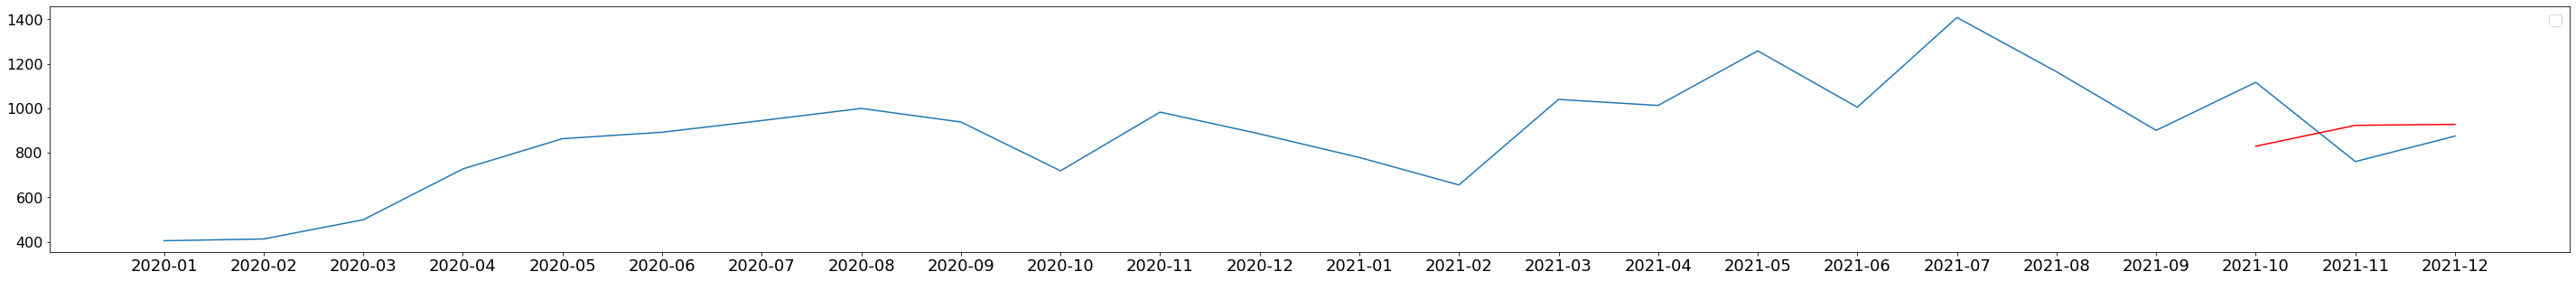

In [1487]:
plt.figure(figsize=(50, 5))
plt.plot(df_proj_mon.index, df_proj_mon['product'])
plt.plot(df_proj_mon.index, df_proj_mon['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()